## Install the library and toolboxs

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import random
import shutil
import numpy as np
from PIL import Image
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split

!pip install ipython-autotime

%load_ext autotime
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
# Check GPU
!nvidia-smi

## Load test data

In [0]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive/')

In [3]:
# Load the test data
level = 3
variable_folder =  "/content/drive/My Drive/Dataset"
file_name = "dataset_test" + "_level" + str(level) + ".pkl"
with open(os.path.join(variable_folder, file_name), 'rb') as f:
    slide_patches, tumor_indicator, slides_original, masks_original = pickle.load(f)

time: 26.6 s


In [4]:
# Extract only those patches with cells
slide_patches_cell = []
tumor_indicator_cell = []
indicator_cell = []
for slide_patch, tumor_ind in zip(slide_patches, tumor_indicator):
    if np.mean(np.std(slide_patch, axis=-1)) > 5:
        slide_patches_cell.append(slide_patch)
        tumor_indicator_cell.append(tumor_ind)
        indicator_cell.append(1)
    else:
        indicator_cell.append(0)
        
print("Number of patches with cells: {:d}/{:d} ({:.1f}%)".format(len(tumor_indicator_cell),
                                                                len(tumor_indicator), 100*len(tumor_indicator_cell)/len(tumor_indicator)))        

Number of patches with cells: 84849/255360 (33.2%)
time: 29.7 s


In [0]:
# Check the patches to see if they contain cells
index_shuffle = np.arange(len(slide_patches_cell))
np.random.shuffle(index_shuffle)
dim_axis = [10, 3]
fig = plt.figure(figsize=(24,7))
for i in range(dim_axis[1]):
    for j in range(dim_axis[0]):
        ax = fig.add_subplot(dim_axis[1], dim_axis[0], i*dim_axis[0]+j+1)
        plt.imshow(slide_patches_cell[index_shuffle[i*dim_axis[0]+j]])
        im_gray = rgb2gray(slide_patches_cell[index_shuffle[i*dim_axis[0]+j]])
        std_cross_channel = np.std(slide_patches_cell[index_shuffle[i*dim_axis[0]+j]], axis=-1)
        # ax.set_title(str(round(np.mean(im_gray), 2)) + ", " + str(round(np.mean(std_cross_channel), 2)))
        ax.set_title("tumor: " + str(tumor_indicator_cell[index_shuffle[i*dim_axis[0]+j]]) + ", std: " + str(round(np.mean(std_cross_channel), 2)))
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)

plt.savefig("patches_with_cell.png")

# Test the custom model

## Preprocess the data for the custom model

In [9]:
# Preprocess the patches to match the requirement of model input
X_test = np.array(slide_patches_cell).astype('float32') / 255.
y_test = np.array(tumor_indicator_cell)


time: 620 ms


## Load and check the model

In [10]:
# Load the model
model_path = "/content/drive/My Drive/Train_model/custom_model_relu_rescaleX_dataAugFlipShift0.2Shear"
custom_model = tf.keras.models.load_model(model_path)


time: 21.5 s


In [0]:
# Check the model
custom_model.summary()

## Run model prediction on test data

In [11]:
# Run the model on test data
label_predict_score = custom_model.predict(X_test)
label_predict = np.round(label_predict_score)
label_predict = np.squeeze(label_predict)

time: 9.91 s


## Compute the accuracy, f-1 score and area under ROC

In [0]:
# Compute the f-1 score
from sklearn.metrics import classification_report
report_classification = classification_report(label_predict, y_test)
print(report_classification)

In [0]:
from sklearn.metrics import roc_auc_score, roc_curve

# Compute area under ROC
area_roc = roc_auc_score(y_test, label_predict_score)

# Plot ROC 
fpr, tpr, thresholds = roc_curve(y_test, label_predict_score)
plt.figure(figsize=(7, 7))
plt.plot([0, 1], [0, 1], '--')
plt.plot(fpr, tpr)
plt.title('Area under ROC: ' + str(round(area_roc, 3)))
plt.savefig("custom_roc")

# Test InceptionV3

## Preprocess the data for the custom model

### For method 1 and 2

In [47]:
# Preprocess the patches to match the requirement of model input
X_test = (np.array(slide_patches_cell).astype('float32') / 255.) * 2. - 1.
y_test = np.array(tumor_indicator_cell)

# Resize the data patches to match required input size of InceptionV3
X_test = tf.image.resize(
                        X_test,
                        [75, 75],
                        method='bilinear',
                        antialias=True)


time: 11.3 s


### For method 3 (no need to upsample the data)

In [42]:
# Preprocess the patches to match the requirement of model input
X_test = (np.array(slide_patches_cell).astype('float32') / 255.) * 2. - 1.
y_test = np.array(tumor_indicator_cell)


time: 826 ms


## Load and check the model

### Load the model

In [55]:
drive_root = '/content/drive/My Drive/'
checkpoint_dir = os.path.join(drive_root, "Checkpoints", "InceptionResnetV3-DataAug-Freeze40", "best_model.hdf5")
new_model = tf.keras.models.load_model(checkpoint_dir)

time: 32.8 s


In [0]:
new_model.summary()

## Run model prediction on test data

In [56]:
# Run the model on test data
label_predict_score = new_model.predict(X_test)
label_predict = np.round(label_predict_score)
label_predict = np.squeeze(label_predict)

time: 1min 27s


## Compute the accuracy, f-1 score and area under ROC

In [57]:
# Compute the f-1 score
from sklearn.metrics import classification_report
report_classification = classification_report(label_predict, y_test)
print(report_classification)

              precision    recall  f1-score   support

         0.0       0.66      0.99      0.79     42631
         1.0       0.97      0.48      0.64     42218

    accuracy                           0.73     84849
   macro avg       0.81      0.73      0.71     84849
weighted avg       0.81      0.73      0.71     84849

time: 136 ms


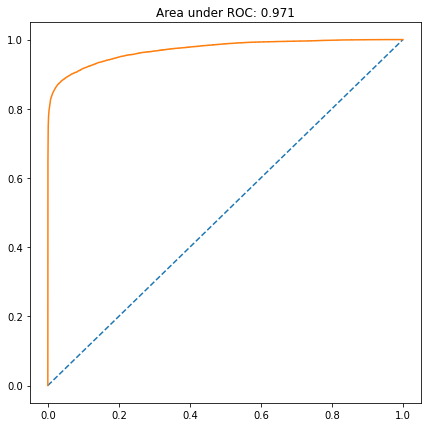

time: 314 ms


In [58]:
from sklearn.metrics import roc_auc_score, roc_curve

# Compute area under ROC
area_roc = roc_auc_score(y_test, label_predict_score)

# Plot ROC 
fpr, tpr, thresholds = roc_curve(y_test, label_predict_score)
plt.figure(figsize=(7, 7))
plt.plot([0, 1], [0, 1], '--')
plt.plot(fpr, tpr)
plt.title('Area under ROC: ' + str(round(area_roc, 3)))
plt.savefig("InceptionV3_m1")

# Visualize the prediction

### Put the labels of patches with cell back to the original indicator list

In [60]:
tumor_indicator_predict = list(indicator_cell)
count = 0
for i in range(len(tumor_indicator_predict)):
    if tumor_indicator_predict[i] == 1:
        tumor_indicator_predict[i] = label_predict[count]
        count = count + 1

time: 58.2 ms


### Plot result for slide 1

In [59]:
save_dir = "/content/drive/My Drive/Test_result/InceptionResnetV2/"
print("Save directory is", save_dir)
if os.path.exists(save_dir):
  print("Save folder already exists")
else:
  print("Creating a save directory")
  os.makedirs(save_dir)

Save directory is /content/drive/My Drive/Test_result/InceptionResnetV2/
Creating a save directory
time: 11.3 ms


#### Save the original slides and masks

In [0]:
# Get the original slide and mask
slide_to_plot = 0
im_slide_whole = slides_original[slide_to_plot]
im_width =  im_slide_whole.shape[1]
im_height =  im_slide_whole.shape[0]
im_mask_whole = 255 * masks_original[slide_to_plot]

# Make canvas images
canvas_slide = Image.new('RGB', (im_width, im_height), 'white')
canvas_slide.paste(Image.fromarray(im_slide_whole, 'RGB'), (0, 0))
canvas_mask = Image.new('RGB', (im_width, im_height), 'white')
canvas_mask.paste(Image.fromarray(im_mask_whole, 'RGB'), (0, 0))

# Save the images
canvas_slide.save(os.path.join(save_dir, str(slide_to_plot) + "_slide_original.png"))
canvas_mask.save(os.path.join(save_dir, str(slide_to_plot) + "_mask_original.png"))
del canvas_slide
del canvas_mask

time: 21 s


#### Save the patches and mask prediction

In [61]:
# Put together the patches
slide_to_plot = 0
im_slide_whole = slides_original[slide_to_plot]
im_width =  im_slide_whole.shape[1]
im_height =  im_slide_whole.shape[0]
patch_size = 32
n_step_width = im_width // patch_size
n_step_height = im_height // patch_size
# canvas_slide = Image.new('RGB', (patch_size * n_step_width, patch_size * n_step_height), 'white')
canvas_mask = Image.new('RGB', (patch_size * n_step_width, patch_size * n_step_height), 'white')
mask_blank = np.zeros((patch_size, patch_size))
mask_tumor = 255 * np.ones((patch_size, patch_size))
index = 0
for i in range(n_step_width):
    for j in range(n_step_height):
        # canvas_slide.paste(Image.fromarray(slide_patches[index], 'RGB'), (i*patch_size, j*patch_size))
        if tumor_indicator_predict[index] == 0:
            canvas_mask.paste(Image.fromarray(mask_blank), (i*patch_size, j*patch_size))
        else:
            canvas_mask.paste(Image.fromarray(mask_tumor), (i*patch_size, j*patch_size))
        index += 1

# Save images
# canvas_slide.save(os.path.join(save_dir, str(slide_to_plot) + "_slide_patches.png"))
canvas_mask.save(os.path.join(save_dir, str(slide_to_plot) + "_mask_predict.png"))
# del canvas_slide
del canvas_mask

time: 8.23 s


#### Plot a heatmap

In [40]:
# Assemble all patches (including background)
tumor_indicator_score = list(indicator_cell)
count = 0
for i in range(len(tumor_indicator_score)):
    if tumor_indicator_score[i] == 1:
        tumor_indicator_score[i] = label_predict_score[count]
        count = count + 1

# Put together the patches
slide_to_plot = 0
im_slide_whole = slides_original[slide_to_plot]
im_width =  im_slide_whole.shape[1]
im_height =  im_slide_whole.shape[0]
patch_size = 32
n_step_width = im_width // patch_size
n_step_height = im_height // patch_size
canvas_heat = Image.new('RGB', (patch_size * n_step_width, patch_size * n_step_height), 'white')
mask_tumor = np.zeros((patch_size, patch_size, 3))
mask_tumor[:, :, 0] = 255 
index = 0
for i in range(n_step_width):
    for j in range(n_step_height):
        patch_mask = np.round(mask_tumor * tumor_indicator_score[index]).astype("uint8")
        canvas_heat.paste(Image.fromarray(patch_mask), (i*patch_size, j*patch_size))
        index += 1

canvas_heat.save("InceptionV3_m3_heatmap.png")

time: 9.18 s


### Plot result for slide 2

#### Save the original slides and masks

In [0]:
# Get the original slide and mask
slide_to_plot = 1
im_slide_whole = slides_original[slide_to_plot]
im_width =  im_slide_whole.shape[1]
im_height =  im_slide_whole.shape[0]
im_mask_whole = 255 * masks_original[slide_to_plot]

# Make canvas images
canvas_slide = Image.new('RGB', (im_width, im_height), 'white')
canvas_slide.paste(Image.fromarray(im_slide_whole, 'RGB'), (0, 0))
canvas_mask = Image.new('RGB', (im_width, im_height), 'white')
canvas_mask.paste(Image.fromarray(im_mask_whole, 'RGB'), (0, 0))

# Save the images
canvas_slide.save(os.path.join(save_dir, str(slide_to_plot) + "_slide_original.png"))
canvas_mask.save(os.path.join(save_dir, str(slide_to_plot) + "_mask_original.png"))
del canvas_slide
del canvas_mask

time: 24.9 s


#### Save the patches and mask prediction

In [62]:
# Put together the patches
slide_to_plot = 1
im_slide_whole = slides_original[slide_to_plot]
im_width =  im_slide_whole.shape[1]
im_height =  im_slide_whole.shape[0]
patch_size = 32
n_step_width = im_width // patch_size
n_step_height = im_height // patch_size
# canvas_slide = Image.new('RGB', (patch_size * n_step_width, patch_size * n_step_height), 'white')
canvas_mask = Image.new('RGB', (patch_size * n_step_width, patch_size * n_step_height), 'white')
mask_blank = np.zeros((patch_size, patch_size))
mask_tumor = 255 * np.ones((patch_size, patch_size))
for i in range(n_step_width):
    for j in range(n_step_height):
        # canvas_slide.paste(Image.fromarray(slide_patches[index], 'RGB'), (i*patch_size, j*patch_size))
        if tumor_indicator_predict[index] == 0:
            canvas_mask.paste(Image.fromarray(mask_blank), (i*patch_size, j*patch_size))
        else:
            canvas_mask.paste(Image.fromarray(mask_tumor), (i*patch_size, j*patch_size))
        index += 1

# Save images
# canvas_slide.save(os.path.join(save_dir, str(slide_to_plot) + "_slide_patches.png"))
canvas_mask.save(os.path.join(save_dir, str(slide_to_plot) + "_mask_predict.png"))
# del canvas_slide
del canvas_mask

time: 11.7 s


#### Plot a heatmap

In [41]:
# Assemble all patches (including background)
tumor_indicator_score = list(indicator_cell)
count = 0
for i in range(len(tumor_indicator_score)):
    if tumor_indicator_score[i] == 1:
        tumor_indicator_score[i] = label_predict_score[count]
        count = count + 1

# Put together the patches
slide_to_plot = 1
im_slide_whole = slides_original[slide_to_plot]
im_width =  im_slide_whole.shape[1]
im_height =  im_slide_whole.shape[0]
patch_size = 32
n_step_width = im_width // patch_size
n_step_height = im_height // patch_size
canvas_heat = Image.new('RGB', (patch_size * n_step_width, patch_size * n_step_height), 'white')
mask_tumor = np.zeros((patch_size, patch_size, 3))
mask_tumor[:, :, 0] = 255 
for i in range(n_step_width):
    for j in range(n_step_height):
        patch_mask = np.round(mask_tumor * tumor_indicator_score[index]).astype("uint8")
        canvas_heat.paste(Image.fromarray(patch_mask), (i*patch_size, j*patch_size))
        index += 1

canvas_heat.save("InceptionV3_m3_heatmap2.png")

time: 13.3 s
